In [ ]:
#Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished



Cross-Validation Results:
Average Accuracy: 0.9344 (±0.0037)
Average Precision: 0.9450 (±0.0062)
Average Recall: 0.9227 (±0.0112)
Average F1: 0.9336 (±0.0041)
Average ROC AUC: 0.9843 (±0.0010)

Aggregated Evaluation:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.94      8190
       Event       0.94      0.92      0.93      8192

    accuracy                           0.93     16382
   macro avg       0.93      0.93      0.93     16382
weighted avg       0.93      0.93      0.93     16382



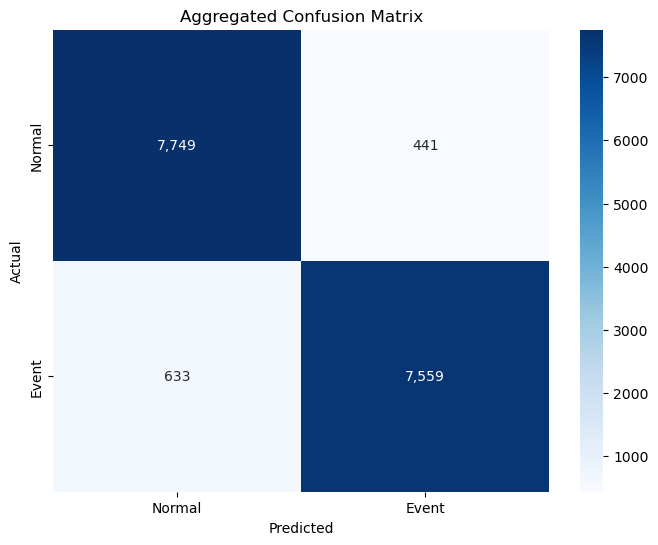

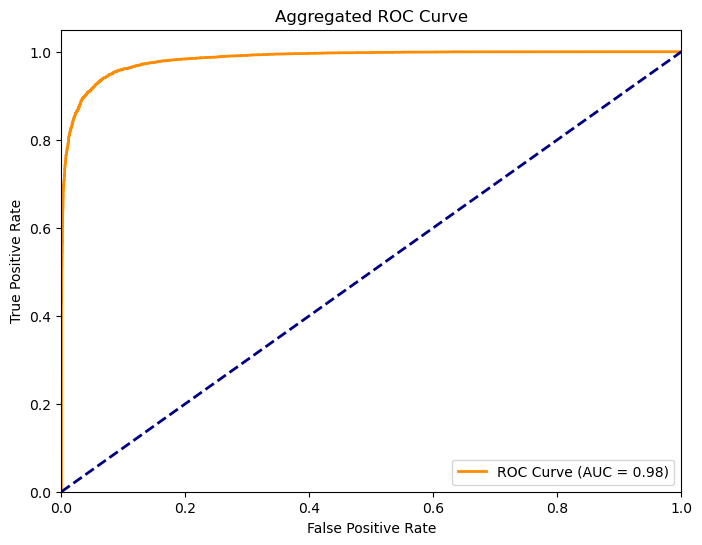

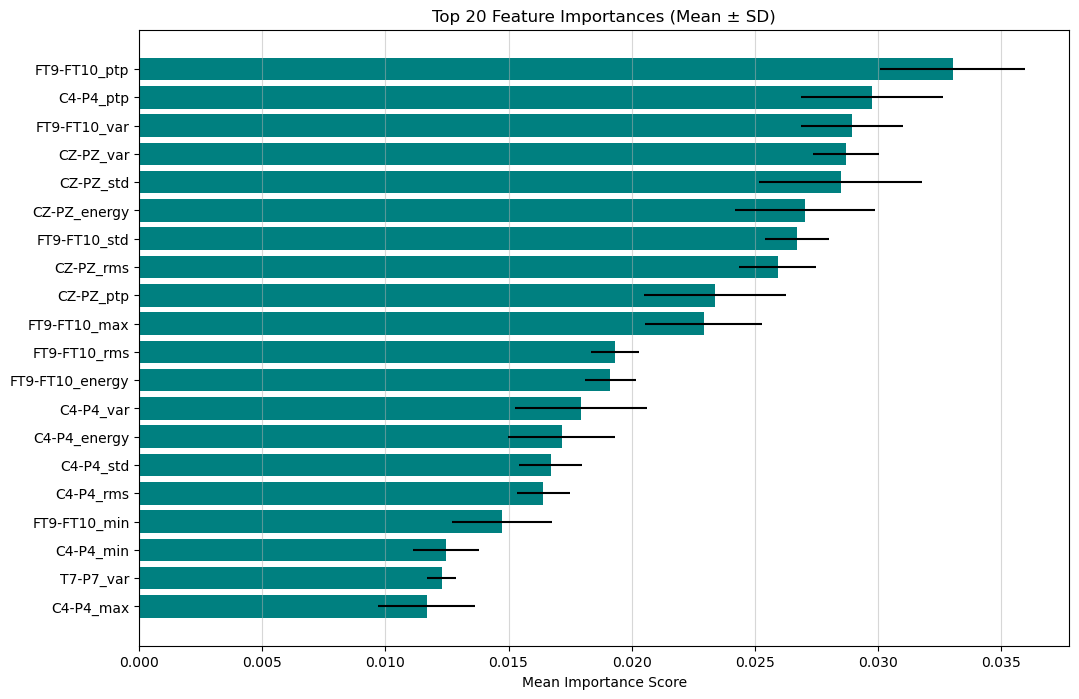

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# Load features
df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv').dropna()

# Configuration
N_SPLITS = 5
N_JOBS = -1
N_ESTIMATORS = 1000
RANDOM_STATE = None

# Prepare data
X = df.drop('target', axis=1)
y = df['target']
features = X.columns.tolist()

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Initialize metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Storage for final aggregation
all_y_test = []
all_y_pred = []
all_y_proba = []
feature_importances = []

def process_fold(train_idx, test_idx, X, y):
    """Process one fold with full CPU utilization"""
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Class weights
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
    weight_dict = {cls: w for cls, w in zip(classes, weights)}
    
    # Model training
    rf = RandomForestClassifier(
        n_estimators=N_ESTIMATORS,
        max_depth=15,
        class_weight=weight_dict,
        n_jobs=N_JOBS,
        verbose=2,
        random_state=RANDOM_STATE,
        criterion='gini'
    )
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'importances': rf.feature_importances_
    }

# Parallel processing of folds
results = Parallel(n_jobs=min(N_SPLITS, N_JOBS), verbose=10)(
    delayed(process_fold)(train_idx, test_idx, X, y)
    for train_idx, test_idx in skf.split(X, y)
)

# Aggregate results
for result in results:
    all_y_test.extend(result['y_test'])
    all_y_pred.extend(result['y_pred'])
    all_y_proba.extend(result['y_proba'])
    feature_importances.append(result['importances'])
    
    # Calculate fold metrics
    metrics['accuracy'].append(accuracy_score(result['y_test'], result['y_pred']))
    metrics['precision'].append(precision_score(result['y_test'], result['y_pred']))
    metrics['recall'].append(recall_score(result['y_test'], result['y_pred']))
    metrics['f1'].append(f1_score(result['y_test'], result['y_pred']))
    metrics['roc_auc'].append(roc_auc_score(result['y_test'], result['y_proba']))

# Calculate average feature importances
mean_importances = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# Print metrics
print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f} (±{np.std(metrics['accuracy']):.4f})")
print(f"Average Precision: {np.mean(metrics['precision']):.4f} (±{np.std(metrics['precision']):.4f})")
print(f"Average Recall: {np.mean(metrics['recall']):.4f} (±{np.std(metrics['recall']):.4f})")
print(f"Average F1: {np.mean(metrics['f1']):.4f} (±{np.std(metrics['f1']):.4f})")
print(f"Average ROC AUC: {np.mean(metrics['roc_auc']):.4f} (±{np.std(metrics['roc_auc']):.4f})")

# Final evaluation on all predictions
print("\nAggregated Evaluation:")
print(classification_report(all_y_test, all_y_pred, target_names=['Normal', 'Event']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Normal', 'Event'],
            yticklabels=['Normal', 'Event'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Aggregated Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_score(all_y_test, all_y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
indices = np.argsort(mean_importances)[-20:]
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances (Mean ± SD)')
plt.barh(range(len(indices)), mean_importances[indices], xerr=std_importances[indices],
         align='center', color='teal', ecolor='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Mean Importance Score')
plt.grid(axis='x', alpha=0.5)
plt.show()

In [ ]:
#KNN

=== Best Model Test Set Performance ===
Accuracy: 0.9759

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1638
           1       0.98      0.97      0.98      1639

    accuracy                           0.98      3277
   macro avg       0.98      0.98      0.98      3277
weighted avg       0.98      0.98      0.98      3277


=== Cross-Validated Metrics ===
Average Accuracy: 0.9781 (±0.0024)
Average Precision: 0.9781
Average Recall: 0.9781
Average F1-Score: 0.9781

=== Optimal Hyperparameters ===
{'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}


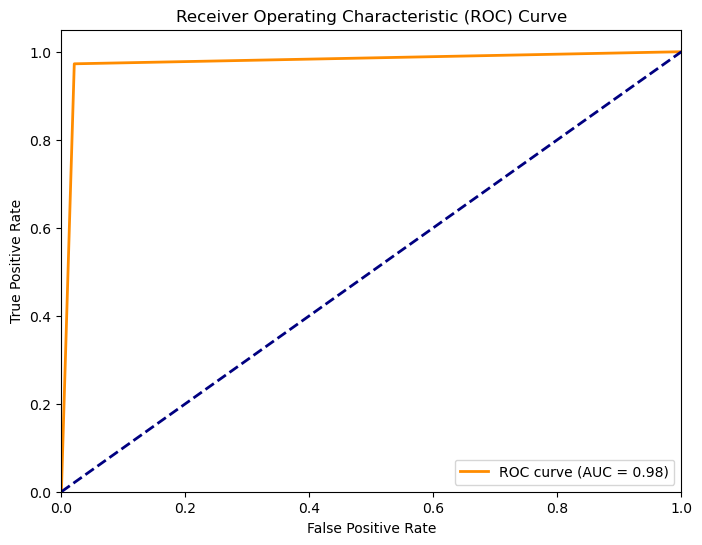

<Figure size 800x600 with 0 Axes>

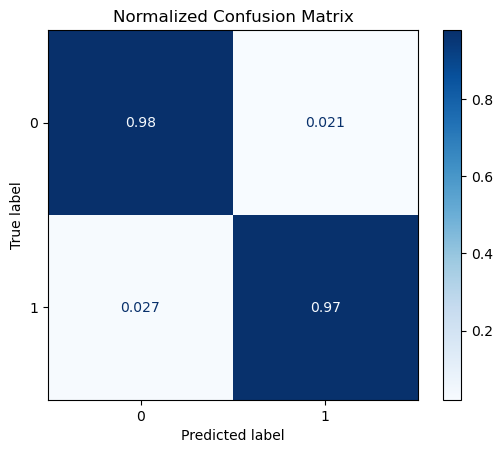

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Load dataset
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create processing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Crucial for KNN performance
    ('knn', KNeighborsClassifier(n_jobs=-1))  # Utilize all CPU cores
])

# Hyperparameter grid for tuning
param_grid = {
    'knn__n_neighbors': list(range(1, 10, 2)),  # Test various neighborhood sizes
    'knn__weights': ['uniform', 'distance'],  # Test weighting schemes
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

# Configure grid search with stratified k-fold
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring='accuracy',
    n_jobs=-1  # Utilize all CPU cores for parallel processing
)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Test set evaluation
y_pred = best_model.predict(X_test)
print("=== Best Model Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f} (±{cv_results['test_accuracy'].std():.4f})")
print(f"Average Precision: {cv_results['test_precision_macro'].mean():.4f}")
print(f"Average Recall: {cv_results['test_recall_macro'].mean():.4f}")
print(f"Average F1-Score: {cv_results['test_f1_macro'].mean():.4f}")

# Display best parameters
print("\n=== Optimal Hyperparameters ===")
print(grid_search.best_params_)

y_proba = best_model.predict_proba(X_test)
n_classes = len(best_model.classes_)

# For binary classification
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test, y_test,
    display_labels=best_model.classes_,
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
#SVM

Best Parameters from GridSearchCV:
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

Test Set Accuracy: 85.78%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1638
           1       0.83      0.90      0.86      1639

    accuracy                           0.86      3277
   macro avg       0.86      0.86      0.86      3277
weighted avg       0.86      0.86      0.86      3277



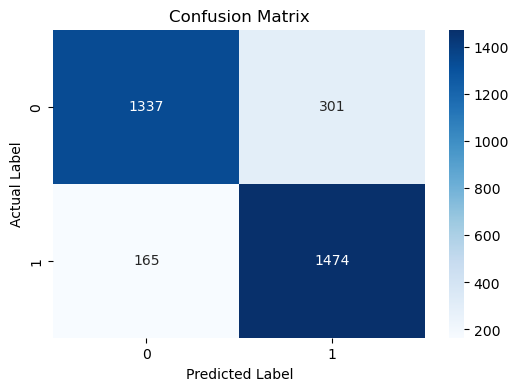

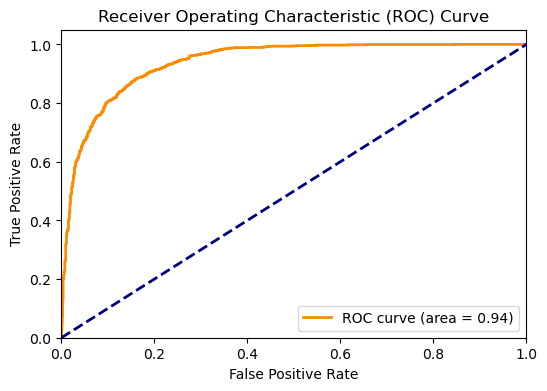

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score)

# -------------------------------
# Load your EEG time-domain features
# -------------------------------
# Assumes 'eeg_features.csv' has feature columns and a 'label' column.
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

# Separate features and target labels
X = data.drop('target', axis=1)
y = data['target']

# -------------------------------
# Split data into training and testing sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# -------------------------------
# Set up Grid Search with K-Fold Cross Validation
# -------------------------------
# SVM with probability=True to enable ROC curve plotting
svc = SVC(probability=True, random_state=0)

# Define parameter grid: try various kernels and optionally adjust C and gamma.
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [100],
    'gamma': ['scale']
}

# Using 5-fold cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid_search = GridSearchCV(svc, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

# -------------------------------
# Evaluate the Best Model on Test Set
# -------------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Set Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------------------
# Plot Confusion Matrix using Seaborn
# -------------------------------
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#LGBM

Fitting 3 folds for each of 32 candidates, totalling 96 fits
=== Advanced Metrics ===
Accuracy: 0.9561
Precision: 0.9611
Recall: 0.9506
F1 Score: 0.9558
ROC AUC: 0.9915

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1638
           1       0.96      0.95      0.96      1639

    accuracy                           0.96      3277
   macro avg       0.96      0.96      0.96      3277
weighted avg       0.96      0.96      0.96      3277



<Figure size 800x600 with 0 Axes>

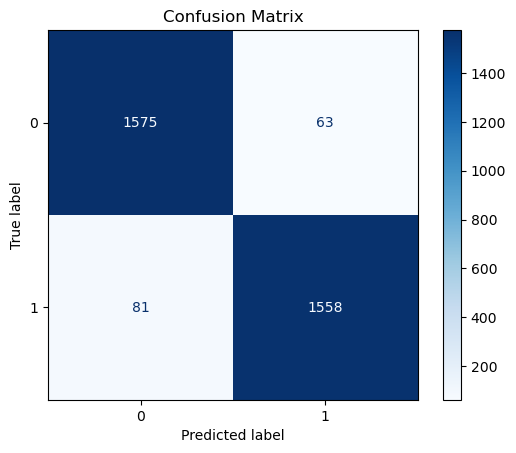

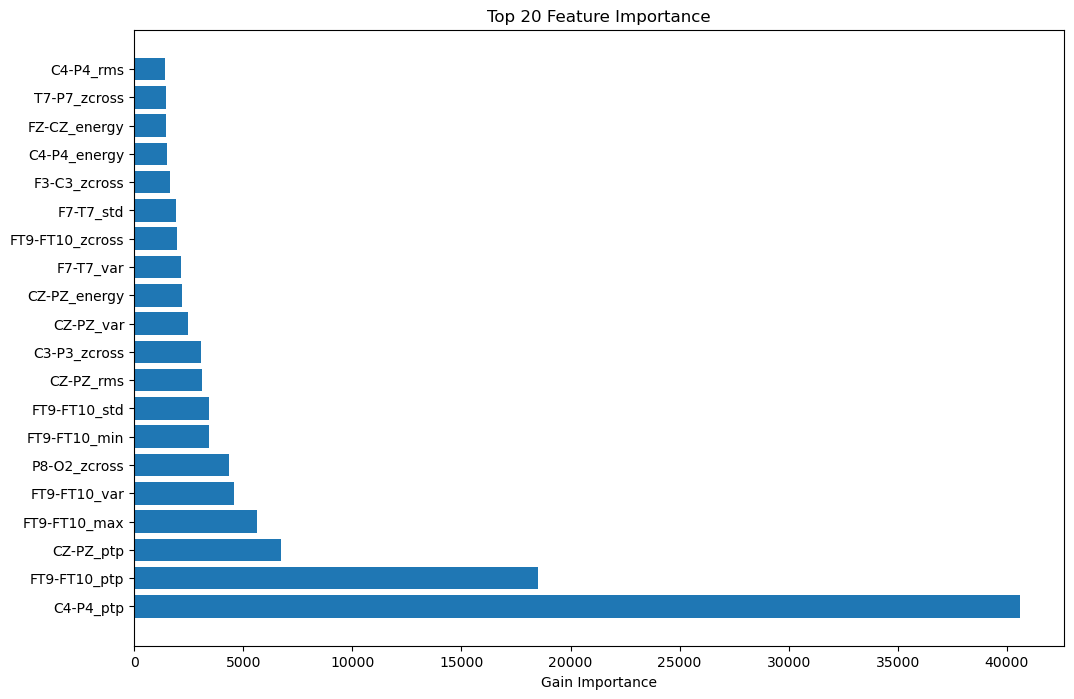

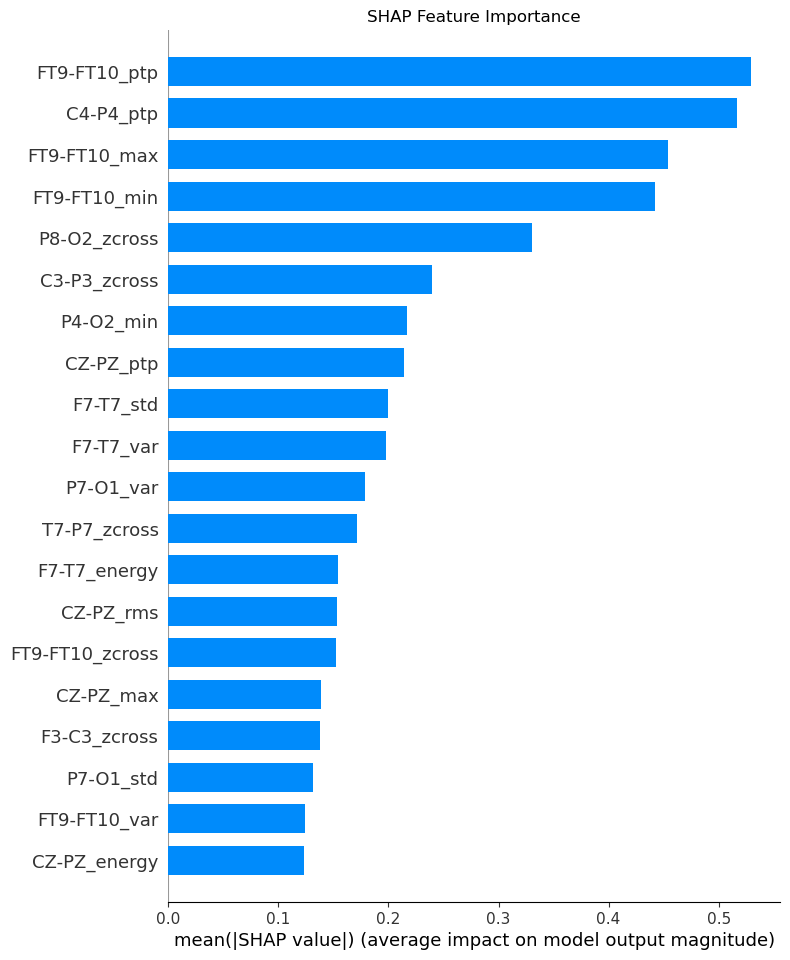

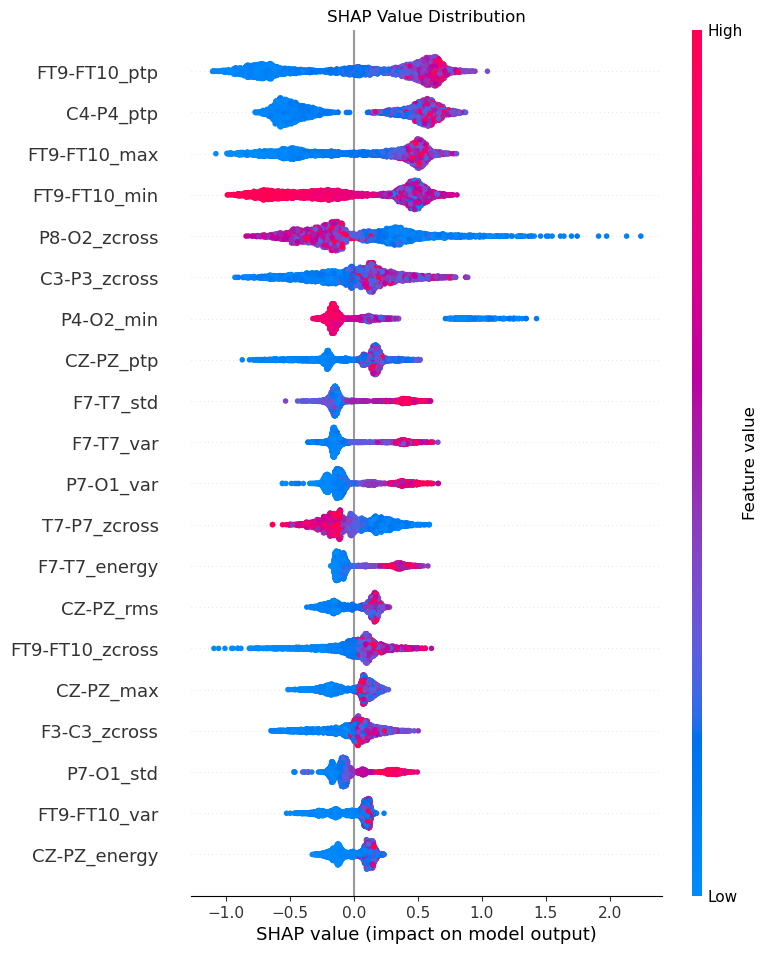

KeyError: 'training'

<Figure size 1200x600 with 0 Axes>

In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load data
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Advanced preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate class weights
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Custom LightGBM dataset creation
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

# Advanced parameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],  # Different boosting types
    'num_leaves': [63],        # Control tree complexity
    'max_depth': [ 7, 15],           # Limit tree depth
    'learning_rate': [ 0.05],
    'n_estimators': [200],
    'subsample': [0.8, 1.0],            # Stochastic gradient boosting
    'colsample_bytree': [0.8, 1.0],     # Feature fraction
    'reg_alpha': [0.1],           # L1 regularization
    'reg_lambda': [0.1],          # L2 regularization
    'min_child_samples': [20],      # Prevent overfitting
    'class_weight': [None, 'balanced'],
    'device': ['gpu']
}

# Advanced model configuration
model = lgb.LGBMClassifier(
    objective='binary',  # Change for multiclass
    metric='binary_logloss',
    boosting_type='gbdt',
    importance_type='gain',
    device='gpu',
    n_jobs=-1,
    verbose=-1
)

# Nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter optimization
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Advanced evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return y_proba

# Feature Importance Visualization
def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Gain Importance')
    plt.show()

# SHAP Value Analysis
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # If binary classification, shap_values will be a list with two arrays
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]  # Use the SHAP values for the positive class
    
    # SHAP Feature Importance (Bar Plot)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.show()
    
    # SHAP Value Distribution (Summary Plot)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()


# Learning Curve Analysis
def plot_learning_curve(model, X, y):
    results = model.evals_result_
    plt.figure(figsize=(12, 6))
    plt.plot(results['training']['binary_logloss'], label='Train')
    plt.plot(results['validation']['binary_logloss'], label='Validation')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_feature_importance(best_model, X.columns)
shap_analysis(best_model, X_test)
plot_learning_curve(best_model, X_train, y_train)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print(f"Average Training Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))

In [ ]:
#HGB

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Binning 0.024 GB of training data: 0.156 s
Binning 0.003 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 224 trees in 3.307 s, (6944 total leaves)
Time spent computing histograms: 1.577s
Time spent finding best splits:  0.851s
Time spent applying splits:      0.164s
Time spent predicting:           0.015s
=== Advanced Metrics ===
Accuracy: 0.9597
Precision: 0.9660
Recall: 0.9530
F1 Score: 0.9595
ROC AUC: 0.9923

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1638
           1       0.97      0.95      0.96      1639

    accuracy                           0.96      3277
   macro avg       0.96      0.96      0.96      3277
weighted avg       0.96      0.96      0.96      3277



<Figure size 800x600 with 0 Axes>

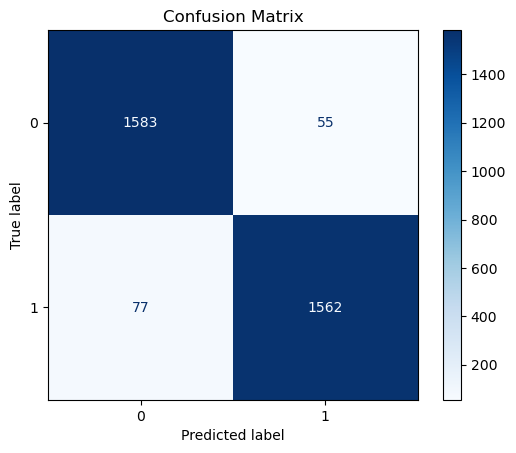

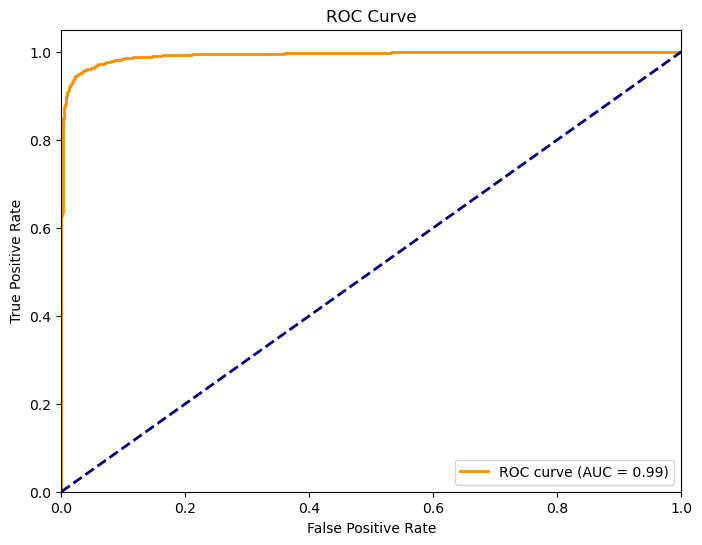

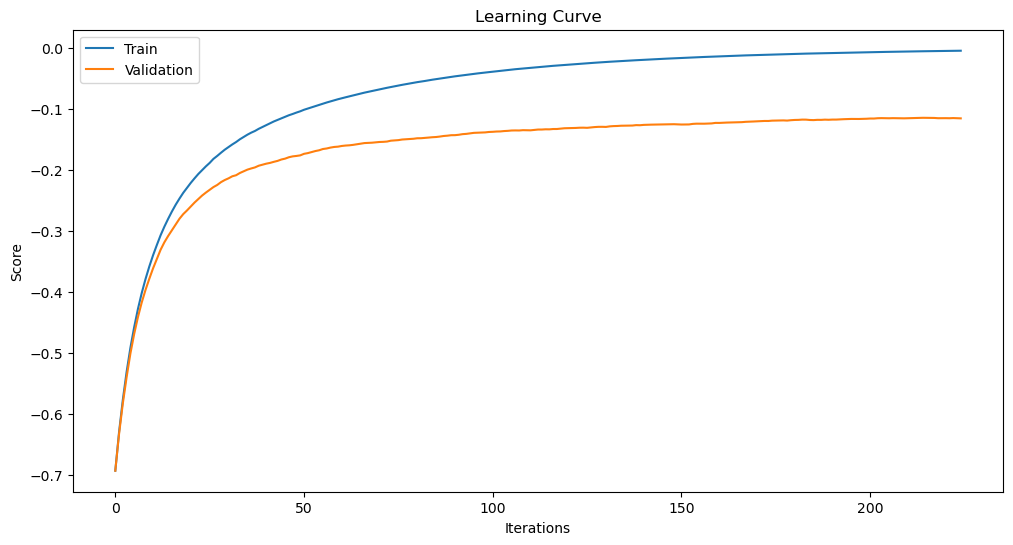


=== Cross-Validated Metrics ===
Average Validation Accuracy: 0.9614
Average Validation ROC AUC: 0.9930
Average Training Accuracy: 0.9960

Training vs Validation Scores:
   Fold  Train Accuracy  Val Accuracy  Train ROC AUC  Val ROC AUC
0     1        0.995803      0.966128       0.999877     0.994916
1     2        0.996871      0.960635       0.999740     0.993224
2     3        0.995193      0.953907       0.999447     0.990252
3     4        0.996185      0.963675       0.999475     0.993737
4     5        0.995880      0.962454       0.999738     0.992897


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Load data
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Advanced train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Advanced parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 300],
    'max_depth': [3, 7, None],
    'max_leaf_nodes': [15, 31],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1],
    'max_bins': [128],
    'scoring': ['loss', 'accuracy'],
    'early_stopping': [True]
}

# Advanced model configuration
model = HistGradientBoostingClassifier(
    class_weight='balanced',
    random_state=42,
    verbose=1,
    n_iter_no_change=10,
    validation_fraction=0.1
)

# Nested cross-validation setup
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter optimization
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Advanced evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_proba


# Learning Curve Analysis
def plot_learning_curve(model):
    train_scores = model.train_score_
    validation_scores = model.validation_score_
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_scores, label='Train')
    plt.plot(validation_scores, label='Validation')
    plt.title('Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_learning_curve(best_model)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print(f"Average Training Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))

In [ ]:
#XGBOOST

In [11]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.9 MB/s eta 0:01:21
   ---------------------------------------- 1.0/150.0 MB 2.0 MB/s eta 0:01:15
   ---------------------------------------- 1.6/150.0 MB 2.2 MB/s eta 0:01:08
    --------------------------------------- 2.4/150.0 MB 2.6 MB/s eta 0:00:58
    --------------------------------------- 3.1/150.0 MB 2.8 MB/s eta 0:00:52
   - -------------------------------------- 3.9/150.0 MB 3.1 MB/s eta 0:00:48
   - -------------------------------------- 5.2/150.0 MB 3.5 MB/s eta 0:00:42
   - -------------------------------------- 6.6/150.0 MB 3.8 MB/s eta 0:00:38
   -- ------------------------------------- 8.1/150.0 MB 4.2 MB/s eta 0:00:34
   -- ------------------------------------- 10.0/150.0 MB 4.7 MB/s eta 0:00:30
   --- ------------------------------------ 12.8/150.0 MB 5.6 MB/s eta 0:00:2

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[0]	validation_0-logloss:0.69319
[1]	validation_0-logloss:0.69332
[2]	validation_0-logloss:0.69336
[3]	validation_0-logloss:0.69357
[4]	validation_0-logloss:0.69392
[5]	validation_0-logloss:0.69434
[6]	validation_0-logloss:0.69385
[7]	validation_0-logloss:0.69437
[8]	validation_0-logloss:0.69493
[9]	validation_0-logloss:0.69558
[10]	validation_0-logloss:0.69630
[11]	validation_0-logloss:0.69705
[12]	validation_0-logloss:0.69781
[13]	validation_0-logloss:0.69859
[14]	validation_0-logloss:0.69928
[15]	validation_0-logloss:0.70021
[16]	validation_0-logloss:0.70123
[17]	validation_0-logloss:0.70241
[18]	validation_0-logloss:0.70359
[19]	validation_0-logloss:0.70451
[20]	validation_0-logloss:0.70564
[21]	validation_0-logloss:0.70664
[22]	validation_0-logloss:0.70664
[23]	validation_0-logloss:0.70812
[24]	validation_0-logloss:0.70880
[25]	validation_0-logloss:0.70748
[26]	validation_0-logloss:0.70877
[27]	validation_0-logloss:0.70984
[28]	validation_0-logloss:0.70848
[29]	validation_0-loglos

<Figure size 800x600 with 0 Axes>

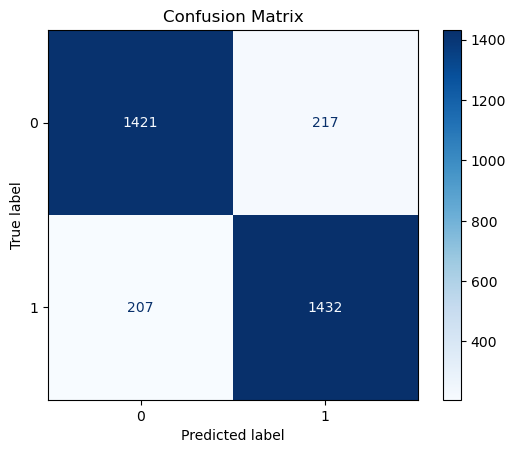

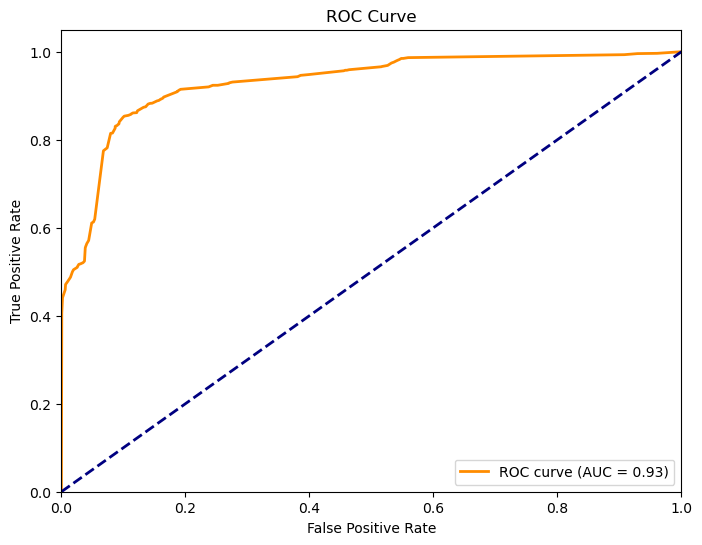

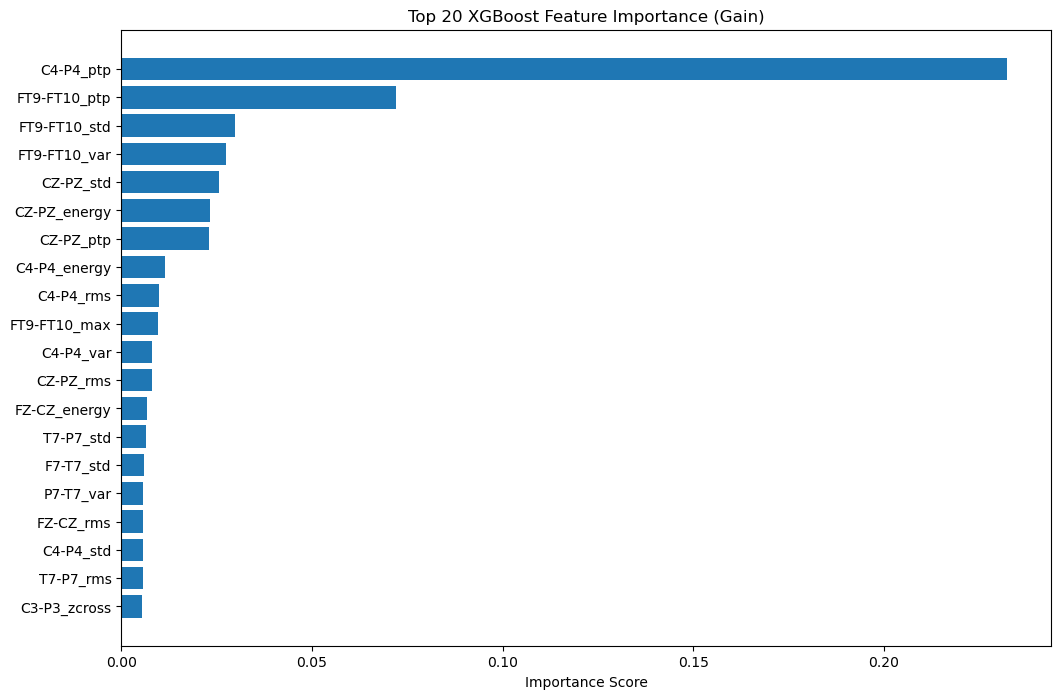

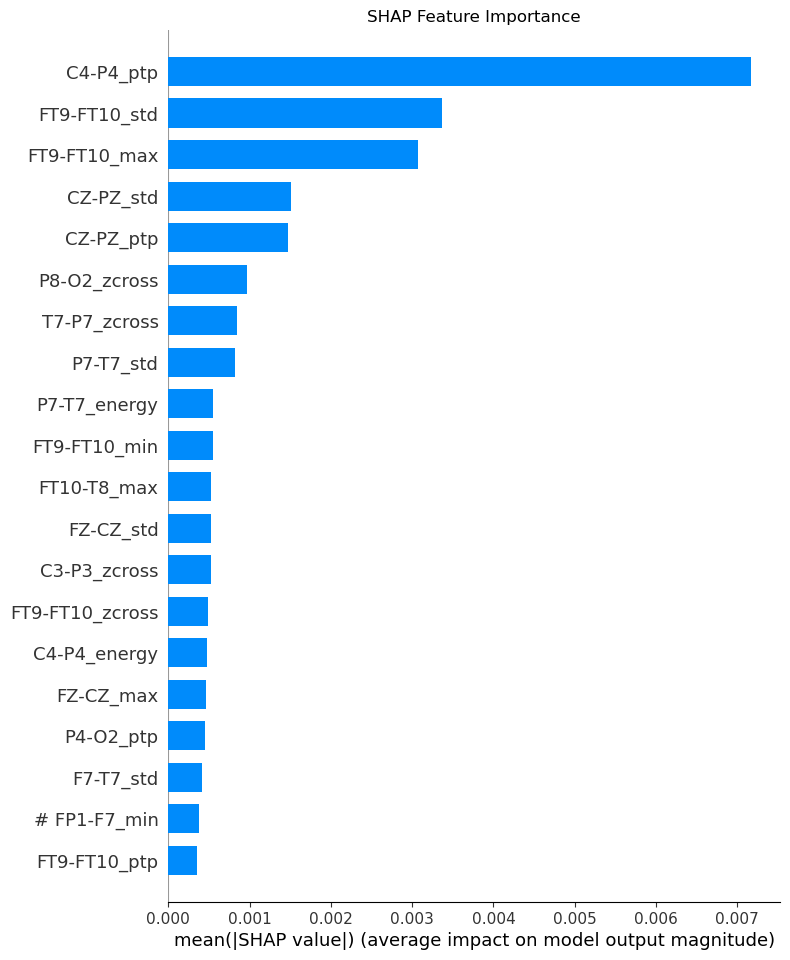

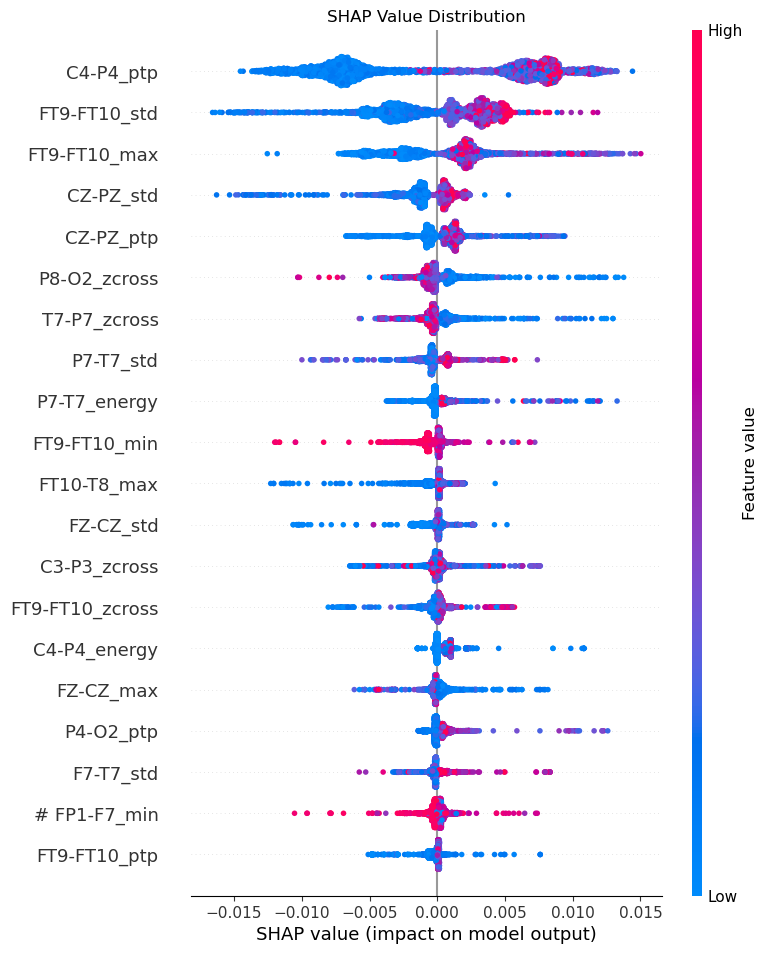

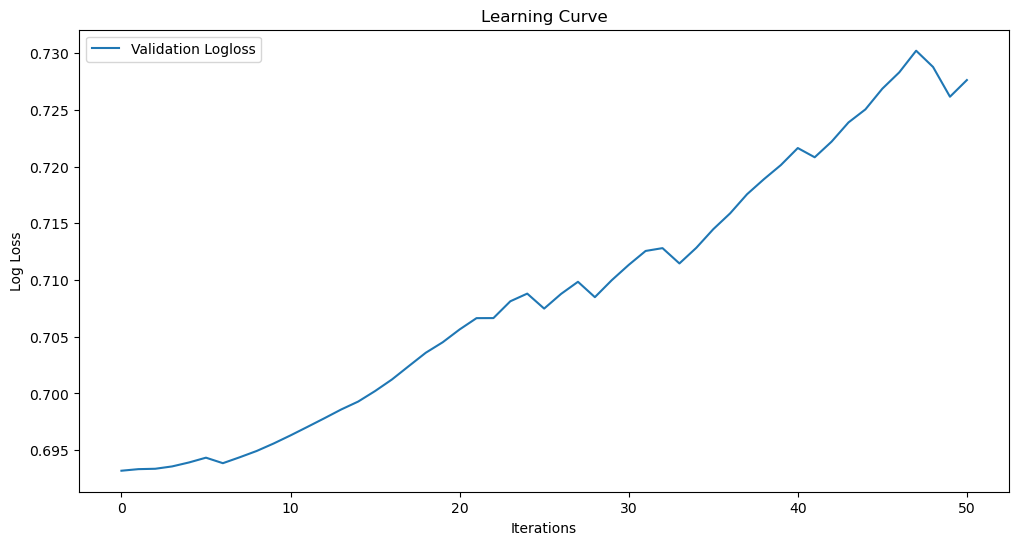


=== Cross-Validated Metrics ===


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\sklearn\pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\training.py", line 184, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\callback.py", line 267, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\callback.py", line 267, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\MOOC.fi\Jupyter\env\Lib\site-packages\xgboost\callback.py", line 463, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.


In [15]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to convert array back to DataFrame with feature names
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # If X is already a DataFrame, simply return it.
        if isinstance(X, pd.DataFrame):
            return X
        return pd.DataFrame(X, columns=self.columns)

# Load data
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')
X = data.drop('target', axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Advanced parameter grid
param_grid = {
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 6, 9], 
    'xgb__subsample': [0.6, 0.8],
    'xgb__colsample_bytree': [0.6, 0.8], 
    'xgb__gamma': [0, 0.1],
    'xgb__reg_alpha': [0, 0.1],
    'xgb__reg_lambda': [0, 0.1],
    'xgb__scale_pos_weight': [1, None],  # For class imbalance
    'xgb__tree_method': ['hist'],

    
}

# Create pipeline with scaling, DataFrame conversion, and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('to_df', DataFrameTransformer(columns=X.columns)),
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=1000,  # Use early stopping
        early_stopping_rounds=50,
        random_state=42,
        tree_method='hist',
        device = 'cuda', # GPU-accelerated histogram-based algorithm
    ))
])

# Advanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Fit grid search with eval_set for early stopping on the XGBoost estimator
grid_search.fit(X_train, y_train, xgb__eval_set=[(X_test, y_test)])
best_model = grid_search.best_estimator_

# Advanced evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("=== Advanced Metrics ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_proba

# Feature Importance Visualization
def plot_feature_importance(model):
    xgb_feat_imp = model.named_steps['xgb'].feature_importances_
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_feat_imp
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 XGBoost Feature Importance (Gain)')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis()
    plt.show()

# SHAP Explainability
def shap_analysis(model, X):
    # Transform data with scaler and DataFrameTransformer if available
    if 'to_df' in model.named_steps:
        X_processed = model.named_steps['to_df'].transform(model.named_steps['scaler'].transform(X))
    else:
        X_processed = X
    explainer = shap.TreeExplainer(model.named_steps['xgb'])
    shap_values = explainer.shap_values(X_processed)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()

# Learning Curve Plot
def plot_learning_curve(model):
    results = model.named_steps['xgb'].evals_result()
    plt.figure(figsize=(12, 6))
    plt.plot(results['validation_0']['logloss'], label='Validation Logloss')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Execute evaluation
y_proba = evaluate_model(best_model, X_test, y_test)
plot_feature_importance(best_model)
shap_analysis(best_model, X_test)
plot_learning_curve(best_model)

# Cross-validated metrics
print("\n=== Cross-Validated Metrics ===")
cv_results = cross_validate(
    best_model,
    X, y,
    cv=cv,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    n_jobs=-1,
    return_train_score=True
)

print(f"Average Validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Validation ROC AUC: {np.mean(cv_results['test_roc_auc']):.4f}")
print("\nTraining vs Validation Scores:")
print(pd.DataFrame({
    'Fold': range(1, 6),
    'Train Accuracy': cv_results['train_accuracy'],
    'Val Accuracy': cv_results['test_accuracy'],
    'Train ROC AUC': cv_results['train_roc_auc'],
    'Val ROC AUC': cv_results['test_roc_auc']
}))


In [ ]:
#1D-CNN

In [14]:
!pip install tensorflow

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 2.6 MB/s eta 0:02:26
   ---------------------------------------- 1.6/376.0 MB 2.8 MB/s eta 0:02:14
   ---------------------------------------- 2.4/376.0 MB 3.2 MB/s eta 0:01:58
   ---------------------------------------- 3.4/376.0 MB 3.7 MB/s eta 0:01:42
    --------------------------------------- 4.7/376.0 MB 4.1 MB/s eta 0:01:32
    --------------------------------------- 6.3/376.0 MB 4.7 MB/s eta 0:01:19
    --------------------------------------- 8.4/376.0 MB 5.4 MB/s eta 0:01:08
   - -------------------------------------- 10.7/376.0 MB 6.1 MB/s eta 0:01:00
   - -------------------------------------- 13.6/376.0 MB 7.0 MB/s eta 0:00:52
   - -------------------------------------- 17.0/376.0 MB 8.0 MB/s eta 0:00:46
   -- ------------------------------------- 21.8/376.0 MB 9.2 MB/s eta 0:00

In [21]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 12.6 MB/s eta 0:03:19
   ---------------------------------------- 0.0/2.5 GB 25.6 MB/s eta 0:01:38
   ---------------------------------------- 0.0/2.5 GB 26.6 MB/s eta 0:01:34
   ---------------------------------------- 0.0/2.5 GB 25.4 MB/s eta 0:01:38
   ---------------------------------------- 0.0/2.5 GB 26.7 MB/s eta 0:01:33
    --------------------------------------- 0.0/2.5 GB 27.7 MB/s eta 0:01:30
    --------------------------------------- 0.0/2.5 GB 28.0 MB/s eta 0:01:28
    --------------------------------------- 0.0/2.5 GB 29.2 MB/s eta 0:01:24
    --------------------------------------- 0.1/2.5 GB 29.8 MB/s eta 0:01:22
    -

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load and preprocess data (unchanged)
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Total features: {len(df.columns)-1}")
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        p_t = targets * probs + (1 - targets) * (1 - probs)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

# Updated Neural Network Architecture with BatchNorm
class EEGClassifier(nn.Module):
    def __init__(self, input_dim=23):
        super(EEGClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.output = nn.Linear(64, 1)  # Output raw logits
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.output(x)

# Modified training function with learning rate scheduler and early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=200):
    model.to(device)
    scaler = GradScaler()
    best_accuracy = 0.0
    patience = 10  # Number of epochs to wait before early stopping
    trigger_times = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).float().view(-1, 1)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs)
                predicted = (probabilities >= 0.5).float().squeeze()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Val Accuracy: {accuracy:.2f}%')
        
        # Step the scheduler based on validation accuracy
        scheduler.step(accuracy)
        
        # Early stopping (optional)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break
    
    print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

# Main execution with optimized data loading and model training
if __name__ == '__main__':
    # Load data
    X_train, X_test, y_train, y_test = load_data('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
    
    # Convert to CPU tensors first
    train_features = torch.tensor(X_train, dtype=torch.float32)
    train_labels = torch.tensor(y_train, dtype=torch.float32)
    test_features = torch.tensor(X_test, dtype=torch.float32)
    test_labels = torch.tensor(y_test, dtype=torch.float32)
    
    # Create DataLoaders with pin_memory for faster GPU transfer
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    batch_size = 1024
    num_workers = 4  # Adjust based on your system
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True,
                              persistent_workers=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_memory=True,
                             persistent_workers=False)
    
    # Initialize model and optimizer
    model = EEGClassifier(input_dim=train_features.shape[1])
    
    # Toggle between BCEWithLogitsLoss and FocalLoss
    use_focal_loss = True
    if use_focal_loss:
        criterion = FocalLoss(alpha=0.25, gamma=2)
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
    
    # Initialize learning rate scheduler based on validation accuracy
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    # Train the model
    train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=20)


Using device: cuda
Total features: 23


Epoch 1/20 | Loss: 0.0254 | Val Accuracy: 84.10%
Epoch 2/20 | Loss: 0.0239 | Val Accuracy: 84.77%
Epoch 3/20 | Loss: 0.0235 | Val Accuracy: 85.23%
Epoch 4/20 | Loss: 0.0232 | Val Accuracy: 85.14%
Epoch 5/20 | Loss: 0.0230 | Val Accuracy: 85.79%
Epoch 6/20 | Loss: 0.0228 | Val Accuracy: 85.82%
Epoch 7/20 | Loss: 0.0227 | Val Accuracy: 85.81%
Epoch 8/20 | Loss: 0.0226 | Val Accuracy: 86.09%
Epoch 9/20 | Loss: 0.0225 | Val Accuracy: 86.24%
Epoch 10/20 | Loss: 0.0224 | Val Accuracy: 86.19%
Epoch 11/20 | Loss: 0.0223 | Val Accuracy: 86.32%
Epoch 12/20 | Loss: 0.0222 | Val Accuracy: 86.35%
Epoch 13/20 | Loss: 0.0222 | Val Accuracy: 86.14%
Epoch 14/20 | Loss: 0.0221 | Val Accuracy: 86.37%
Epoch 15/20 | Loss: 0.0221 | Val Accuracy: 86.63%
Epoch 16/20 | Loss: 0.0220 | Val Accuracy: 86.59%
Epoch 17/20 | Loss: 0.0220 | Val Accuracy: 86.54%
Epoch 18/20 | Loss: 0.0220 | Val Accuracy: 86.31%
Epoch 19/20 | Loss: 0.0219 | Val Accuracy: 86.60%
Epoch 20/20 | Loss: 0.0219 | Val Accuracy: 86.70%
Best Vali

Using device: cuda




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:05<00:00, 20.33it/s]

Epoch 1/40
Train Loss: 0.3736 | Val Loss: 0.3404
Train Acc: 83.00% | Val Acc: 84.75%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 22.14it/s]

Epoch 2/40
Train Loss: 0.3340 | Val Loss: 0.3171
Train Acc: 85.13% | Val Acc: 85.92%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.70it/s]

Epoch 3/40
Train Loss: 0.3159 | Val Loss: 0.3009
Train Acc: 86.09% | Val Acc: 86.87%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.94it/s]

Epoch 4/40
Train Loss: 0.3030 | Val Loss: 0.2916
Train Acc: 86.76% | Val Acc: 87.32%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.97it/s]

Epoch 5/40
Train Loss: 0.2928 | Val Loss: 0.2809
Train Acc: 87.27% | Val Acc: 87.83%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.80it/s]

Epoch 6/40
Train Loss: 0.2841 | Val Loss: 0.2729
Train Acc: 87.71% | Val Acc: 88.24%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.87it/s]

Epoch 7/40
Train Loss: 0.2761 | Val Loss: 0.2661
Train Acc: 88.14% | Val Acc: 88.65%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 20.87it/s]

Epoch 8/40
Train Loss: 0.2693 | Val Loss: 0.2580
Train Acc: 88.47% | Val Acc: 88.99%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.36it/s]

Epoch 9/40
Train Loss: 0.2628 | Val Loss: 0.2526
Train Acc: 88.79% | Val Acc: 89.24%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.61it/s]

Epoch 10/40
Train Loss: 0.2568 | Val Loss: 0.2467
Train Acc: 89.06% | Val Acc: 89.62%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.30it/s]

Epoch 11/40
Train Loss: 0.2514 | Val Loss: 0.2419
Train Acc: 89.38% | Val Acc: 89.86%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 22.28it/s]

Epoch 12/40
Train Loss: 0.2465 | Val Loss: 0.2369
Train Acc: 89.58% | Val Acc: 90.06%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 20.93it/s]

Epoch 13/40
Train Loss: 0.2414 | Val Loss: 0.2332
Train Acc: 89.86% | Val Acc: 90.37%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:05<00:00, 20.54it/s]

Epoch 14/40
Train Loss: 0.2372 | Val Loss: 0.2279
Train Acc: 90.04% | Val Acc: 90.57%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 21.03it/s]

Epoch 15/40
Train Loss: 0.2330 | Val Loss: 0.2244
Train Acc: 90.26% | Val Acc: 90.77%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 22.26it/s]

Epoch 16/40
Train Loss: 0.2290 | Val Loss: 0.2202
Train Acc: 90.46% | Val Acc: 90.93%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.44it/s]

Epoch 17/40
Train Loss: 0.2248 | Val Loss: 0.2163
Train Acc: 90.66% | Val Acc: 91.11%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.12it/s]

Epoch 18/40
Train Loss: 0.2216 | Val Loss: 0.2134
Train Acc: 90.82% | Val Acc: 91.30%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.65it/s]

Epoch 19/40
Train Loss: 0.2182 | Val Loss: 0.2115
Train Acc: 91.00% | Val Acc: 91.36%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.37it/s]

Epoch 20/40
Train Loss: 0.2151 | Val Loss: 0.2076
Train Acc: 91.14% | Val Acc: 91.56%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.56it/s]

Epoch 21/40
Train Loss: 0.2120 | Val Loss: 0.2052
Train Acc: 91.28% | Val Acc: 91.69%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.19it/s]

Epoch 22/40
Train Loss: 0.2089 | Val Loss: 0.2028
Train Acc: 91.41% | Val Acc: 91.75%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.31it/s]

Epoch 23/40
Train Loss: 0.2069 | Val Loss: 0.2000
Train Acc: 91.53% | Val Acc: 91.98%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.00it/s]

Epoch 24/40
Train Loss: 0.2036 | Val Loss: 0.1988
Train Acc: 91.67% | Val Acc: 92.01%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.91it/s]

Epoch 25/40
Train Loss: 0.2011 | Val Loss: 0.1978
Train Acc: 91.80% | Val Acc: 92.13%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.59it/s]

Epoch 26/40
Train Loss: 0.1990 | Val Loss: 0.1929
Train Acc: 91.91% | Val Acc: 92.28%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.15it/s]

Epoch 27/40
Train Loss: 0.1966 | Val Loss: 0.1911
Train Acc: 92.02% | Val Acc: 92.36%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.94it/s]

Epoch 28/40
Train Loss: 0.1938 | Val Loss: 0.1902
Train Acc: 92.14% | Val Acc: 92.40%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.21it/s]

Epoch 29/40
Train Loss: 0.1919 | Val Loss: 0.1875
Train Acc: 92.23% | Val Acc: 92.56%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.12it/s]

Epoch 30/40
Train Loss: 0.1899 | Val Loss: 0.1878
Train Acc: 92.34% | Val Acc: 92.58%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.73it/s]

Epoch 31/40
Train Loss: 0.1877 | Val Loss: 0.1852
Train Acc: 92.44% | Val Acc: 92.68%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.22it/s]

Epoch 32/40
Train Loss: 0.1856 | Val Loss: 0.1827
Train Acc: 92.55% | Val Acc: 92.80%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.13it/s]

Epoch 33/40
Train Loss: 0.1840 | Val Loss: 0.1809
Train Acc: 92.61% | Val Acc: 92.86%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.44it/s]

Epoch 34/40
Train Loss: 0.1819 | Val Loss: 0.1797
Train Acc: 92.72% | Val Acc: 92.90%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 25.16it/s]

Epoch 35/40
Train Loss: 0.1805 | Val Loss: 0.1788
Train Acc: 92.79% | Val Acc: 92.97%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.83it/s]

Epoch 36/40
Train Loss: 0.1787 | Val Loss: 0.1763
Train Acc: 92.86% | Val Acc: 93.11%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.46it/s]

Epoch 37/40
Train Loss: 0.1773 | Val Loss: 0.1764
Train Acc: 92.91% | Val Acc: 93.12%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.36it/s]

Epoch 38/40
Train Loss: 0.1751 | Val Loss: 0.1753
Train Acc: 93.03% | Val Acc: 93.19%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.61it/s]

Epoch 39/40
Train Loss: 0.1733 | Val Loss: 0.1738
Train Acc: 93.11% | Val Acc: 93.22%
-----------------------------------




valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.50it/s]

Epoch 40/40
Train Loss: 0.1722 | Val Loss: 0.1720
Train Acc: 93.17% | Val Acc: 93.32%
-----------------------------------



valuating: 100%|████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.71it/s]


Classification Report:
              precision    recall  f1-score   support

  No Seizure       0.91      0.97      0.94    209715
     Seizure       0.97      0.90      0.93    209715

    accuracy                           0.93    419430
   macro avg       0.94      0.93      0.93    419430
weighted avg       0.94      0.93      0.93    419430

ROC AUC Score: 0.9805
Average Precision: 0.9839


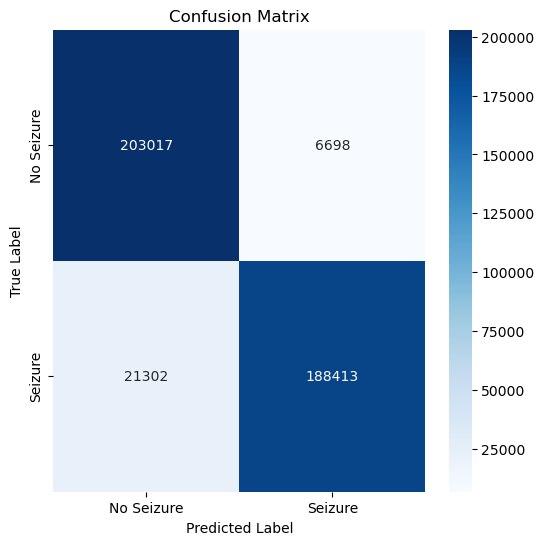

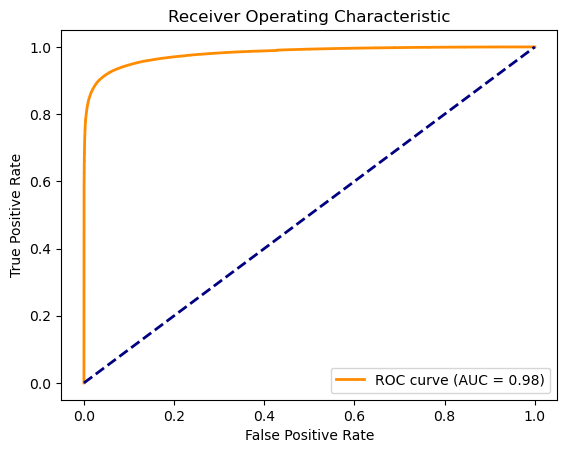

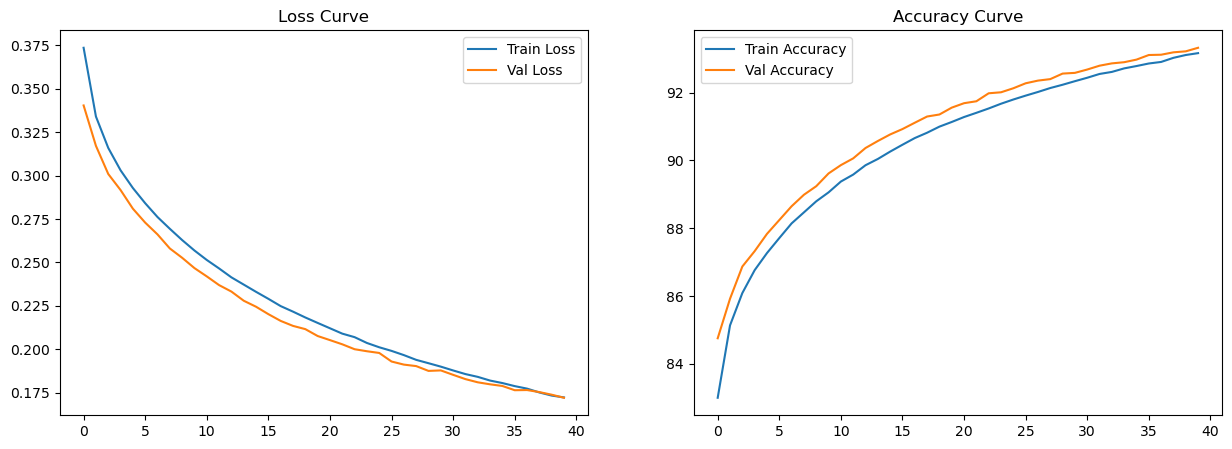

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Set random seeds and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Enhanced Data Loader with optimized memory management
def load_data(file_path, test_size=0.2):
    # Load data in chunks to handle large dataset
    chunk_size = 100000
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    
    X_list, y_list = [], []
    for chunk in chunks:
        X_list.append(chunk.iloc[:, :-1].astype(np.float32))
        y_list.append(chunk.iloc[:, -1].astype(np.int32))
    
    X = pd.concat(X_list, axis=0).values
    y = pd.concat(y_list, axis=0).values
    
    # Split data using index-based split for large datasets
    indices = np.arange(len(X))
    train_idx, test_idx = train_test_split(
        indices, test_size=test_size, random_state=42, stratify=y
    )
    
    # StandardScaler with partial_fit for large data
    scaler = StandardScaler()
    for i in range(0, len(train_idx), chunk_size):
        scaler.partial_fit(X[train_idx[i:i+chunk_size]])
    
    X_train = scaler.transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])
    
    return X_train, X_test, y[train_idx], y[test_idx]

# Enhanced Model Architecture with Skip Connections
class EEGSeizureNet(nn.Module):
    def __init__(self, input_dim=23):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU()
        )
        
        # Hidden layer 1
        self.block1 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Hidden layer 2
        self.block2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Hidden layer 3
        self.block3 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Hidden layer 4
        self.block4 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Hidden layer 5 (reduces to 256 features)
        self.block5 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # Output layer
        self.output = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.input_layer(x)
        # Apply skip connections for blocks with matching dimensions.
        x = x + self.block1(x)
        x = x + self.block2(x)
        x = x + self.block3(x)
        x = x + self.block4(x)
        x = self.block5(x)  # Dimension reduces here; skip connection not applied.
        x = self.output(x)
        return x


# Enhanced Training with Metrics Tracking
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'lr': []
        }
    
    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True).float().view(-1, 1)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc
    
    def evaluate(self, test_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Evaluating"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device).float().view(-1, 1)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                all_probs.append(outputs.cpu())
                all_labels.append(labels.cpu())
                
        epoch_loss = running_loss / len(test_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc, torch.cat(all_probs), torch.cat(all_labels)
    
    def train(self, train_loader, val_loader, epochs=50):
        best_acc = 0.0
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc, _, _ = self.evaluate(val_loader)
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
            print("-----------------------------------")
            
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), "best_model.pth")
    
    def plot_metrics(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(self.history['train_loss'], label='Train Loss')
        ax[0].plot(self.history['val_loss'], label='Val Loss')
        ax[0].set_title('Loss Curve')
        ax[0].legend()
        
        ax[1].plot(self.history['train_acc'], label='Train Accuracy')
        ax[1].plot(self.history['val_acc'], label='Val Accuracy')
        ax[1].set_title('Accuracy Curve')
        ax[1].legend()
        
        plt.show()
    
    def plot_confusion_matrix(self, probs, labels, threshold=0.5):
        y_pred = (probs >= threshold).numpy()
        cm = confusion_matrix(labels.numpy(), y_pred)
        
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                  xticklabels=['No Seizure', 'Seizure'],
                  yticklabels=['No Seizure', 'Seizure'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_roc_curve(self, probs, labels):
        fpr, tpr, _ = roc_curve(labels.numpy(), probs.numpy())
        roc_auc = roc_auc_score(labels.numpy(), probs.numpy())
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
               label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    def full_report(self, test_loader):
        _, _, probs, labels = self.evaluate(test_loader)
        probs = probs.squeeze()
        labels = labels.squeeze()
        
        print("\nClassification Report:")
        print(classification_report(labels.numpy(), (probs >= 0.5).numpy(),
                                target_names=['No Seizure', 'Seizure']))
        
        print(f"ROC AUC Score: {roc_auc_score(labels, probs):.4f}")
        print(f"Average Precision: {average_precision_score(labels, probs):.4f}")
        
        self.plot_confusion_matrix(probs, labels)
        self.plot_roc_curve(probs, labels)
        self.plot_metrics()

# Main Execution
if __name__ == '__main__':
    # Load data with efficient memory management
    X_train, X_test, y_train, y_test = load_data('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
    
    # Create TensorDatasets
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.float32))
    
    # Create DataLoaders with large batch size
    batch_size = 4096  # Adjusted for large dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                            num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           num_workers=4, pin_memory=True)
    
    # Initialize model and components
    model = EEGSeizureNet(input_dim=X_train.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.BCELoss()
    
    # Train model
    trainer = Trainer(model, device, optimizer, criterion)
    trainer.train(train_loader, test_loader, epochs=40)
    
    # Generate full performance report
    trainer.full_report(test_loader)